In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pyMRAW
import pyidi
import os
import sys
sys.path.insert(0, os.path.realpath('__file__'))

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Performing mode-shape magnification based on an existing pyIDI analysis

In [4]:
# Specify the ".cih" file that has the same name as the ".mraw" file

filename = 'data/data_showcase.cih'

# Make an instance of "pyIDI" class

video = pyidi.pyIDI(filename)

# Create a reference image from the first 10 frames

reference_image = np.average(video.mraw[:10], axis=0)

# Calculate image intensity gradients on the reference image

grad0, grad1 = np.gradient(reference_image)

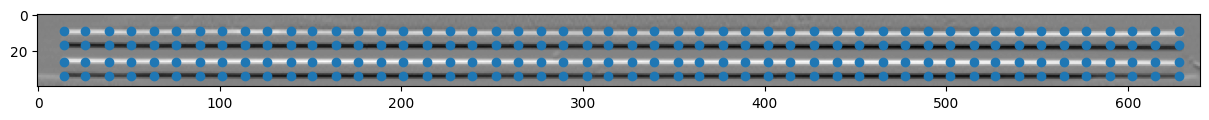

In [177]:
# Define points, where displacements will be identified, preferably at locations
# with high image intensity gradients.

n_cols = 50

x_coords = np.linspace(14, 628, n_cols, dtype=int)

y_coords = np.array([9, 17, 26, 34])

inds = np.array(np.meshgrid(y_coords, x_coords)).T.reshape(-1, 2)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(grad0, 'gray')
ax.scatter(inds[:, 1], inds[:, 0])

In [188]:
# Set the points attribute

video.set_points(inds)

# Define the mode shape to be magnified

A = np.sin(2 * np.pi * np.linspace(0, 1, 2 * n_cols - 1))[:n_cols]
A = np.tile(A, (1, 4))

B = np.zeros((4 * n_cols))

mode_shape = np.vstack((A, B)).T

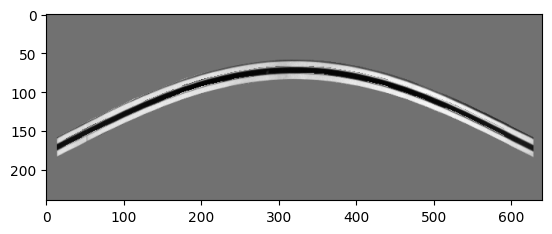

In [189]:
res = pyidi.postprocessing.mode_shape_magnification(video = video, 
                                                    displacements = mode_shape, 
                                                    magnification_factor = 100,
                                                    background_brightness = 1,
                                                    show_undeformed=False)

plt.imshow(res, 'gray')

### Explicitly specifiying the "image" and "points " atributes

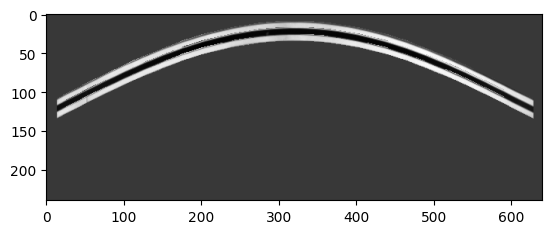

In [196]:
res = pyidi.postprocessing.mode_shape_magnification(displacements = mode_shape,
                                                    magnification_factor = 100,
                                                    image = reference_image,
                                                    points = inds,
                                                    background_brightness = 0.5,
                                                    show_undeformed=False)

plt.imshow(res, 'gray')

### Generating a video of magnifed mode-shape

In [198]:
# pyidi.postprocessing.animate(displacements = mode_shape,
#                              magnification_factor = 50,
#                              video = video,
#                              fps = 30,
#                              n_periods = 5,
#                              filename = 'my_folder/my_video',
#                              output_format = 'gif',
#                              background_brightness = 0.2)

Video saved in file: my_folder/my_video.gif
